### Some Installation


In [1]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install segmentation_models_pytorch
!pip uninstall opencv-python
!pip install opencv-contrib-python
!pip install scikit-learn
!pip install albumentations
!pip install transformers
!apt-get update
!apt-get install ffmpeg -y
!apt-get install libsm6 -y
!apt-get install libxext6 -y
!apt-get install unzip

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Hit:1 http://free.nchc.org.tw/ubuntu bionic InRelease
Hit:2 http://free.nchc.org.tw/ubuntu bionic-updates InRelease                  
Hit:3 http://free.nchc.org.tw/ubuntu bionic-backports InRelease                
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1581 B]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease              
Err:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Ign:8 https://deb.obspy.org xenial InRelease                               
Err:10 https://deb.obspy.org xenial Release   

### Import Libraries

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed May 10 01:30:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.76       Driver Version: 515.76       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:20:00.0 Off |                  N/A |
| 36%   56C    P8    30W / 200W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# ### for_multi_GPU
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch

print(torch.cuda.device_count())
print(torch.cuda.is_available())

1
True


In [4]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
import argparse
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
# from albumentations.torch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2
warnings.filterwarnings("ignore")

In [5]:
import segmentation_models_pytorch as smp

### Set Path

In [6]:
# import os
# from google.colab import drive

# drive.mount('/content/drive')

# ROOT_PATH = '/home/yasaisen/Desktop/11_research/11_research_main/lab_08'
ROOT_PATH = '/home'

In [7]:
# sample_submission_path = '../input/siim-acr-pneumothorax-segmentation/sample_submission.csv'
# sample_submission_path = '/content/drive/My Drive/11_research_main/lab_01/CXR_Dataset/stage_2_sample_submission.csv'

train_rle_path = os.path.join(ROOT_PATH, 'SIIM_ACR_dataset', 'train-rle.csv')
data_folder = os.path.join(ROOT_PATH, 'SIIM_ACR_dataset', 'train_png')
test_data_folder = os.path.join(ROOT_PATH, 'SIIM_ACR_dataset', 'test_png')

In [8]:
def checkpath(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [9]:
# model

Version = '230510_v0.0.1'

root_folder = os.path.abspath(os.path.join(ROOT_PATH, Version))

model_DIR = os.path.abspath(os.path.join(root_folder, 'model.pth'))
checkpath(root_folder)

### GroupVit Import

In [10]:
import collections.abc
import math
from dataclasses import dataclass
from typing import Any, Optional, Tuple, Union

import numpy as np
import torch
import torch.utils.checkpoint
from torch import nn

# from ...activations import ACT2FN
from transformers.activations import ACT2FN

# from ...modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
from transformers.modeling_outputs import BaseModelOutput, BaseModelOutputWithPooling
# from ...modeling_utils import PreTrainedModel
from transformers.modeling_utils import PreTrainedModel
# from ...utils import (
#     ModelOutput,
#     add_start_docstrings,
#     add_start_docstrings_to_model_forward,
#     logging,
#     replace_return_docstrings,
# )
from transformers.utils import (
    ModelOutput,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
# from .configuration_groupvit import GroupViTConfig, GroupViTTextConfig, GroupViTVisionConfig
from transformers.models.groupvit.configuration_groupvit import GroupViTConfig, GroupViTTextConfig #, GroupViTVisionConfig

In [11]:
import copy
import os
from collections import OrderedDict
from typing import TYPE_CHECKING, Any, Mapping, Optional, Union

# from ...configuration_utils import PretrainedConfig
from transformers.configuration_utils import PretrainedConfig
# from ...onnx import OnnxConfig
from transformers.onnx import OnnxConfig
# from ...utils import logging
from transformers.utils import logging


if TYPE_CHECKING:
    # from ...processing_utils import ProcessorMixin
    from transformers.processing_utils import ProcessorMixin
    # from ...utils import TensorType
    from transformers.utils import TensorType


logger = logging.get_logger(__name__)

GROUPVIT_PRETRAINED_CONFIG_ARCHIVE_MAP = {
    "nvidia/groupvit-gcc-yfcc": "https://huggingface.co/nvidia/groupvit-gcc-yfcc/resolve/main/config.json",
}

In [12]:
class GroupViTVisionConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`GroupViTVisionModel`]. It is used to instantiate
    an GroupViT model according to the specified arguments, defining the model architecture. Instantiating a
    configuration with the defaults will yield a similar configuration to that of the GroupViT
    [nvidia/groupvit-gcc-yfcc](https://huggingface.co/nvidia/groupvit-gcc-yfcc) architecture.

    Configuration objects inherit from [`PretrainedConfig`] and can be used to control the model outputs. Read the
    documentation from [`PretrainedConfig`] for more information.

    Args:
        hidden_size (`int`, *optional*, defaults to 384):
            Dimensionality of the encoder layers and the pooler layer.
        intermediate_size (`int`, *optional*, defaults to 1536):
            Dimensionality of the "intermediate" (i.e., feed-forward) layer in the Transformer encoder.
        depths (`List[int]`, *optional*, defaults to [6, 3, 3]):
            The number of layers in each encoder block.
        num_group_tokens (`List[int]`, *optional*, defaults to [64, 8, 0]):
            The number of group tokens for each stage.
        num_output_groups (`List[int]`, *optional*, defaults to [64, 8, 8]):
            The number of output groups for each stage, 0 means no group.
        num_attention_heads (`int`, *optional*, defaults to 6):
            Number of attention heads for each attention layer in the Transformer encoder.
        image_size (`int`, *optional*, defaults to 224):
            The size (resolution) of each image.
        patch_size (`int`, *optional*, defaults to 16):
            The size (resolution) of each patch.
        hidden_act (`str` or `function`, *optional*, defaults to `"gelu"`):
            The non-linear activation function (function or string) in the encoder and pooler. If string, `"gelu"`,
            `"relu"`, `"selu"` and `"gelu_new"` ``"quick_gelu"` are supported.
        layer_norm_eps (`float`, *optional*, defaults to 1e-5):
            The epsilon used by the layer normalization layers.
        dropout (`float`, *optional*, defaults to 0.0):
            The dropout probabilitiy for all fully connected layers in the embeddings, encoder, and pooler.
        attention_dropout (`float`, *optional*, defaults to 0.0):
            The dropout ratio for the attention probabilities.
        initializer_range (`float`, *optional*, defaults to 0.02):
            The standard deviation of the truncated_normal_initializer for initializing all weight matrices.
        initializer_factor (`float`, *optional*, defaults to 1.0):
            A factor for initializing all weight matrices (should be kept to 1, used internally for initialization
            testing).

    Example:

    ```python
    >>> from transformers import GroupViTVisionConfig, GroupViTVisionModel

    >>> # Initializing a GroupViTVisionModel with nvidia/groupvit-gcc-yfcc style configuration
    >>> configuration = GroupViTVisionConfig()

    >>> model = GroupViTVisionModel(configuration)

    >>> # Accessing the model configuration
    >>> configuration = model.config
    ```"""

    model_type = "groupvit_vision_model"

    def __init__(
        self,
        hidden_size=384,
        intermediate_size=1536,
        depths=[6, 3, 3],
        num_hidden_layers=12,
        num_group_tokens=[64, 8, 0],
        num_output_groups=[64, 8, 8],
        num_attention_heads=6,
        image_size=1024,
        patch_size=16,
        num_channels=3,
        hidden_act="gelu",
        layer_norm_eps=1e-5,
        dropout=0.0,
        attention_dropout=0.0,
        initializer_range=0.02,
        initializer_factor=1.0,
        assign_eps=1.0,
        assign_mlp_ratio=[0.5, 4],
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.depths = depths
        if num_hidden_layers != sum(depths):
            logger.warning(
                f"Manually setting num_hidden_layers to {num_hidden_layers}, but we expect num_hidden_layers ="
                f" sum(depth) = {sum(depths)}"
            )
        self.num_hidden_layers = num_hidden_layers
        self.num_group_tokens = num_group_tokens
        self.num_output_groups = num_output_groups
        self.num_attention_heads = num_attention_heads
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.hidden_act = hidden_act
        self.layer_norm_eps = layer_norm_eps
        self.dropout = dropout
        self.attention_dropout = attention_dropout
        self.initializer_range = initializer_range
        self.initializer_factor = initializer_factor
        self.assign_eps = assign_eps
        self.assign_mlp_ratio = assign_mlp_ratio

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path: Union[str, os.PathLike], **kwargs) -> "PretrainedConfig":
        config_dict, kwargs = cls.get_config_dict(pretrained_model_name_or_path, **kwargs)

        # get the vision config dict if we are loading from GroupViTConfig
        if config_dict.get("model_type") == "groupvit":
            config_dict = config_dict["vision_config"]

        if "model_type" in config_dict and hasattr(cls, "model_type") and config_dict["model_type"] != cls.model_type:
            logger.warning(
                f"You are using a model of type {config_dict['model_type']} to instantiate a model of type "
                f"{cls.model_type}. This is not supported for all configurations of models and can yield errors."
            )

        return cls.from_dict(config_dict, **kwargs)

In [13]:
logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "nvidia/groupvit-gcc-yfcc"

GROUPVIT_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "nvidia/groupvit-gcc-yfcc",
    # See all GroupViT models at https://huggingface.co/models?filter=groupvit
]

In [14]:
# Copied from transformers.models.bart.modeling_bart._expand_mask
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
    """
    Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
    """
    bsz, src_len = mask.size()
    tgt_len = tgt_len if tgt_len is not None else src_len

    expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)


In [15]:
# contrastive loss function, adapted from
# https://sachinruk.github.io/blog/pytorch/pytorch%20lightning/loss%20function/gpu/2021/03/07/CLIP.html
def contrastive_loss(logits: torch.Tensor) -> torch.Tensor:
    return nn.functional.cross_entropy(logits, torch.arange(len(logits), device=logits.device))

In [16]:
# Copied from transformers.models.clip.modeling_clip.clip_loss with clip->groupvit
def groupvit_loss(similarity: torch.Tensor) -> torch.Tensor:
    caption_loss = contrastive_loss(similarity)
    image_loss = contrastive_loss(similarity.t())
    return (caption_loss + image_loss) / 2.0

In [17]:
def hard_softmax(logits: torch.Tensor, dim: int):
    y_soft = logits.softmax(dim)
    # Straight through.
    index = y_soft.max(dim, keepdim=True)[1]
    y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
    ret = y_hard - y_soft.detach() + y_soft

    return ret

In [18]:
def gumbel_softmax(logits: torch.Tensor, tau: float = 1, hard: bool = False, dim: int = -1) -> torch.Tensor:
    # more stable https://github.com/pytorch/pytorch/issues/41663
    gumbel_dist = torch.distributions.gumbel.Gumbel(
        torch.tensor(0.0, device=logits.device, dtype=logits.dtype),
        torch.tensor(1.0, device=logits.device, dtype=logits.dtype),
    )
    gumbels = gumbel_dist.sample(logits.shape)

    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(logits, memory_format=torch.legacy_contiguous_format).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [19]:
def resize_attention_map(attentions, height, width, align_corners=False):
    """
    Args:
        attentions (`torch.Tensor`): attention map of shape [batch_size, groups, feat_height*feat_width]
        height (`int`): height of the output attention map
        width (`int`): width of the output attention map
        align_corners (`bool`, *optional*): the `align_corner` argument for `nn.functional.interpolate`.

    Returns:
        `torch.Tensor`: resized attention map of shape [batch_size, groups, height, width]
    """

    scale = (height * width // attentions.shape[2]) ** 0.5
    if height > width:
        feat_width = int(np.round(width / scale))
        feat_height = attentions.shape[2] // feat_width
    else:
        feat_height = int(np.round(height / scale))
        feat_width = attentions.shape[2] // feat_height

    batch_size = attentions.shape[0]
    groups = attentions.shape[1]  # number of group token
    # [batch_size, groups, height*width, groups] -> [batch_size, groups, height, width]
    attentions = attentions.reshape(batch_size, groups, feat_height, feat_width)
    attentions = nn.functional.interpolate(
        attentions, size=(height, width), mode="bilinear", align_corners=align_corners
    )
    return attentions

In [20]:
def get_grouping_from_attentions(attentions, hw_shape):
    """
    Args:
        attentions (`tuple(torch.FloatTensor)`: tuple of attention maps returned by `GroupViTVisionTransformer`
        hw_shape (`tuple(int)`): height and width of the output attention map
    Returns:
        `torch.Tensor`: the attention map of shape [batch_size, groups, height, width]
    """

    attn_maps = []
    with torch.no_grad():
        prev_attn_masks = None
        for attn_masks in attentions:
            # [batch_size, num_groups, height x width] -> [batch_size, height x width, num_groups]
            attn_masks = attn_masks.permute(0, 2, 1).contiguous()
            if prev_attn_masks is None:
                prev_attn_masks = attn_masks
            else:
                prev_attn_masks = prev_attn_masks @ attn_masks
            # [batch_size, heightxwidth, num_groups] -> [batch_size, num_groups, heightxwidth] -> [batch_size, num_groups, height, width]
            cur_attn_map = resize_attention_map(prev_attn_masks.permute(0, 2, 1).contiguous(), *hw_shape)
            attn_maps.append(cur_attn_map)

    # [batch_size, num_groups, height, width]
    final_grouping = attn_maps[-1]

    return final_grouping

In [21]:
class GroupViTCrossAttentionLayer(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.attn = GroupViTAttention(config)
        self.norm2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp = GroupViTMLP(config)
        self.norm_post = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, query, key):
        x = query
        x = x + self.attn(query, encoder_hidden_states=key)[0]
        x = x + self.mlp(self.norm2(x))
        x = self.norm_post(x)
        return x

In [22]:
class GroupViTAssignAttention(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.scale = config.hidden_size**-0.5

        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.assign_eps = config.assign_eps

    def get_attn(self, attn, gumbel=True, hard=True):
        if gumbel and self.training:
            attn = gumbel_softmax(attn, dim=-2, hard=hard)
        else:
            if hard:
                attn = hard_softmax(attn, dim=-2)
            else:
                attn = nn.functional.softmax(attn, dim=-2)

        return attn

    def forward(self, query, key):
        value = key
        # [batch_size, query_length, channels]
        query = self.q_proj(query)

        # [batch_size, key_length, channels]
        key = self.k_proj(key)

        # [batch_size, key_length, channels]
        value = self.v_proj(value)

        # [batch_size, query_length, key_length]
        raw_attn = (query @ key.transpose(-2, -1)) * self.scale

        attn = self.get_attn(raw_attn)
        soft_attn = self.get_attn(raw_attn, gumbel=False, hard=False)

        attn = attn / (attn.sum(dim=-1, keepdim=True) + self.assign_eps)

        out = attn @ value

        out = self.proj(out)

        return out, soft_attn

In [23]:
class GroupViTTokenAssign(nn.Module):
    def __init__(self, config: GroupViTVisionConfig, num_group_token, num_output_group):
        super().__init__()
        self.num_output_group = num_output_group
        # norm on group_tokens
        self.norm_tokens = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        assign_mlp_ratio = (
            config.assign_mlp_ratio
            if isinstance(config.assign_mlp_ratio, collections.abc.Iterable)
            else (config.assign_mlp_ratio, config.assign_mlp_ratio)
        )
        tokens_dim, channels_dim = [int(x * config.hidden_size) for x in assign_mlp_ratio]
        self.mlp_inter = GroupViTMixerMLP(config, num_group_token, tokens_dim, num_output_group)
        self.norm_post_tokens = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        # norm on x
        self.norm_x = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pre_assign_attn = GroupViTCrossAttentionLayer(config)

        self.assign = GroupViTAssignAttention(config)
        self.norm_new_x = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.mlp_channels = GroupViTMLP(config, config.hidden_size, channels_dim, config.hidden_size)

    def project_group_token(self, group_tokens):
        """
        Args:
            group_tokens (torch.Tensor): group tokens, [batch_size, num_group_tokens, channels]

        Returns:
            projected_group_tokens (torch.Tensor): [batch_size, num_output_groups, channels]
        """
        # [B, num_output_groups, C] <- [B, num_group_tokens, C]
        projected_group_tokens = self.mlp_inter(group_tokens)
        projected_group_tokens = self.norm_post_tokens(projected_group_tokens)
        return projected_group_tokens

    def forward(self, image_tokens, group_tokens):
        """
        Args:
            image_tokens (`torch.Tensor`): image tokens, of shape [batch_size, input_length, channels]
            group_tokens (`torch.Tensor`): group tokens, [batch_size, num_group_tokens, channels]
        """

        group_tokens = self.norm_tokens(group_tokens)
        image_tokens = self.norm_x(image_tokens)
        # [batch_size, num_output_groups, channels]
        projected_group_tokens = self.project_group_token(group_tokens)
        projected_group_tokens = self.pre_assign_attn(projected_group_tokens, image_tokens)
        new_image_tokens, attention = self.assign(projected_group_tokens, image_tokens)
        new_image_tokens += projected_group_tokens

        new_image_tokens = new_image_tokens + self.mlp_channels(self.norm_new_x(new_image_tokens))

        return new_image_tokens, attention


In [24]:
@dataclass
class GroupViTModelOutput(ModelOutput):
    """
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `return_loss` is `True`):
            Contrastive loss for image-text similarity.
        logits_per_image (`torch.FloatTensor` of shape `(image_batch_size, text_batch_size)`):
            The scaled dot product scores between `image_embeds` and `text_embeds`. This represents the image-text
            similarity scores.
        logits_per_text (`torch.FloatTensor` of shape `(text_batch_size, image_batch_size)`):
            The scaled dot product scores between `text_embeds` and `image_embeds`. This represents the text-image
            similarity scores.
        segmentation_logits (`torch.FloatTensor` of shape `(batch_size, config.num_labels, logits_height, logits_width)`):
            Classification scores for each pixel.

            <Tip warning={true}>

            The logits returned do not necessarily have the same size as the `pixel_values` passed as inputs. This is
            to avoid doing two interpolations and lose some quality when a user needs to resize the logits to the
            original image size as post-processing. You should always check your logits shape and resize as needed.

            </Tip>

        text_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim`):
            The text embeddings obtained by applying the projection layer to the pooled output of
            [`GroupViTTextModel`].
        image_embeds (`torch.FloatTensor` of shape `(batch_size, output_dim`):
            The image embeddings obtained by applying the projection layer to the pooled output of
            [`GroupViTVisionModel`].
        text_model_output (`BaseModelOutputWithPooling`):
            The output of the [`GroupViTTextModel`].
        vision_model_output (`BaseModelOutputWithPooling`):
            The output of the [`GroupViTVisionModel`].
    """

    loss: Optional[torch.FloatTensor] = None
    logits_per_image: torch.FloatTensor = None
    logits_per_text: torch.FloatTensor = None
    segmentation_logits: torch.FloatTensor = None
    text_embeds: torch.FloatTensor = None
    image_embeds: torch.FloatTensor = None
    text_model_output: BaseModelOutputWithPooling = None
    vision_model_output: BaseModelOutputWithPooling = None

    def to_tuple(self) -> Tuple[Any]:
        return tuple(
            self[k] if k not in ["text_model_output", "vision_model_output"] else getattr(self, k).to_tuple()
            for k in self.keys()
        )

In [25]:
class GroupViTPatchEmbeddings(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        image_size: int = 224,
        patch_size: Union[int, Tuple[int, int]] = 16,
        num_channels: int = 3,
        embed_dim: int = 768,
    ):
        super().__init__()
        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.projection = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        if not interpolate_pos_encoding:
            if height != self.image_size[0] or width != self.image_size[1]:
                raise ValueError(
                    f"Input image size ({height}*{width}) doesn't match model"
                    f" ({self.image_size[0]}*{self.image_size[1]})."
                )
        x = self.projection(pixel_values).flatten(2).transpose(1, 2)
        return x

In [26]:
class GroupViTVisionEmbeddings(nn.Module):
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()

        self.patch_embeddings = GroupViTPatchEmbeddings(
            image_size=config.image_size,
            patch_size=config.patch_size,
            num_channels=config.num_channels,
            embed_dim=config.hidden_size,
        )
        num_patches = self.patch_embeddings.num_patches
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches, config.hidden_size))
        self.dropout = nn.Dropout(config.dropout)
        self.layernorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.config = config

    def interpolate_pos_encoding(self, embeddings: torch.Tensor, height: int, width: int) -> torch.Tensor:
        """
        This method allows to interpolate the pre-trained position encodings, to be able to use the model on higher
        resolution images.

        Source:
        https://github.com/facebookresearch/dino/blob/de9ee3df6cf39fac952ab558447af1fa1365362a/vision_transformer.py#L174
        """

        npatch = embeddings.shape[1]
        if npatch == self.position_embeddings.shape[1] and height == width:
            return self.position_embeddings
        patch_pos_embed = self.position_embeddings
        num_original_pos_embed = patch_pos_embed.shape[1]
        dim = embeddings.shape[-1]
        feat_height = height // self.config.patch_size
        feat_width = width // self.config.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        feat_height, feat_width = feat_height + 0.1, feat_width + 0.1
        original_height = original_width = math.sqrt(num_original_pos_embed)
        reshaped_patch_pos_embed = patch_pos_embed.reshape(1, int(original_height), int(original_width), dim).permute(
            0, 3, 1, 2
        )
        scale_factor = (feat_height / original_height, feat_width / original_width)
        patch_pos_embed = nn.functional.interpolate(
            reshaped_patch_pos_embed,
            scale_factor=scale_factor,
            mode="bicubic",
            align_corners=False,
        )
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return patch_pos_embed

    def forward(self, pixel_values: torch.Tensor, interpolate_pos_encoding: bool = False) -> torch.Tensor:
        batch_size, num_channels, height, width = pixel_values.shape
        embeddings = self.patch_embeddings(pixel_values, interpolate_pos_encoding=interpolate_pos_encoding)

        embeddings = self.layernorm(embeddings)

        batch_size, seq_len, _ = embeddings.size()

        # add positional encoding to each token
        if interpolate_pos_encoding:
            embeddings = embeddings + self.interpolate_pos_encoding(embeddings, height, width)
        else:
            embeddings = embeddings + self.position_embeddings

        embeddings = self.dropout(embeddings)

        return embeddings

In [27]:
# Copied from transformers.models.clip.modeling_clip.CLIPTextEmbeddings with CLIP->GroupViT
class GroupViTTextEmbeddings(nn.Module):
    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        embed_dim = config.hidden_size

        self.token_embedding = nn.Embedding(config.vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(config.max_position_embeddings, embed_dim)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
    ) -> torch.Tensor:
        seq_length = input_ids.shape[-1] if input_ids is not None else inputs_embeds.shape[-2]

        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]

        if inputs_embeds is None:
            inputs_embeds = self.token_embedding(input_ids)

        position_embeddings = self.position_embedding(position_ids)
        embeddings = inputs_embeds + position_embeddings

        return embeddings

In [28]:
class GroupViTStage(nn.Module):
    """This corresponds to the `GroupingLayer` class in the GroupViT implementation."""

    def __init__(
        self,
        config: GroupViTVisionConfig,
        depth: int,
        num_prev_group_token: int,
        num_group_token: int,
        num_output_group: int,
    ):
        super().__init__()
        self.depth = depth
        self.num_group_token = num_group_token
        if num_group_token > 0:
            self.group_token = nn.Parameter(torch.zeros(1, num_group_token, config.hidden_size))
        else:
            self.group_token = None
        self.gradient_checkpointing = False
        self.layers = nn.ModuleList([GroupViTEncoderLayer(config) for _ in range(depth)])

        if num_group_token > 0:
            self.downsample = GroupViTTokenAssign(
                config=config,
                num_group_token=num_group_token,
                num_output_group=num_output_group,
            )
        else:
            self.downsample = None

        if num_prev_group_token > 0 and num_group_token > 0:
            self.group_projector = nn.Sequential(
                nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps),
                GroupViTMixerMLP(config, num_prev_group_token, config.hidden_size // 2, num_group_token),
            )
        else:
            self.group_projector = None

    @property
    def with_group_token(self):
        return self.group_token is not None

    def split_x(self, x):
        if self.with_group_token:
            return x[:, : -self.num_group_token], x[:, -self.num_group_token :]
        else:
            return x, None

    def concat_x(self, x: torch.Tensor, group_token: Optional[torch.Tensor] = None) -> torch.Tensor:
        if group_token is None:
            return x
        return torch.cat([x, group_token], dim=1)

    def forward(
        self,
        hidden_states: torch.Tensor,
        prev_group_token: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the grouping tensors of Grouping block.
        """
        if self.with_group_token:
            group_token = self.group_token.expand(hidden_states.size(0), -1, -1)
            if self.group_projector is not None:
                group_token = group_token + self.group_projector(prev_group_token)
        else:
            group_token = None

        x = hidden_states

        cat_x = self.concat_x(x, group_token)
        for layer in self.layers:
            layer_out = layer(cat_x, attention_mask=None, causal_attention_mask=None)
            cat_x = layer_out[0]

        x, group_token = self.split_x(cat_x)

        attention = None
        if self.downsample is not None:
            x, attention = self.downsample(x, group_token)

        outputs = (x, group_token)
        if output_attentions:
            outputs = outputs + (attention,)

        return outputs

In [29]:
class GroupViTMLP(nn.Module):
    def __init__(
        self,
        config: GroupViTVisionConfig,
        hidden_size: Optional[int] = None,
        intermediate_size: Optional[int] = None,
        output_size: Optional[int] = None,
    ):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        hidden_size = hidden_size if hidden_size is not None else config.hidden_size
        intermediate_size = intermediate_size if intermediate_size is not None else config.intermediate_size
        output_size = output_size if output_size is not None else hidden_size
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states

In [30]:
class GroupViTMixerMLP(GroupViTMLP):
    def forward(self, x):
        x = super().forward(x.transpose(1, 2))
        return x.transpose(1, 2)

In [31]:
class GroupViTAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        if self.head_dim * self.num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {self.num_heads})."
            )
        self.scale = self.head_dim**-0.5
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        bsz, tgt_len, embed_dim = hidden_states.size()
        is_cross_attention = encoder_hidden_states is not None

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scale
        if is_cross_attention:
            key_states = self._shape(self.k_proj(encoder_hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(encoder_hidden_states), -1, bsz)
        else:
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        # apply the causal_attention_mask first
        if causal_attention_mask is not None:
            if causal_attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is"
                    f" {causal_attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + causal_attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if output_attentions:
            # this operation is a bit akward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(bsz, tgt_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped


In [32]:
# Copied from transformers.models.clip.modeling_clip.CLIPEncoderLayer with CLIP->GroupViT
class GroupViTEncoderLayer(nn.Module):
    def __init__(self, config: GroupViTConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = GroupViTAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = GroupViTMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        causal_attention_mask: torch.Tensor,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.FloatTensor]:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
                `(config.encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        hidden_states = self.layer_norm1(hidden_states)
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
        )
        hidden_states = residual + hidden_states

        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs

In [33]:
class GroupViTPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = GroupViTConfig
    base_model_prefix = "groupvit"
    supports_gradient_checkpointing = True
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights"""

        init_range = self.config.initializer_range
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=init_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

        factor = self.config.initializer_factor
        if isinstance(module, GroupViTTextEmbeddings):
            module.token_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
            module.position_embedding.weight.data.normal_(mean=0.0, std=factor * 0.02)
        elif isinstance(module, GroupViTAttention):
            factor = self.config.initializer_factor
            in_proj_std = (module.embed_dim**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            out_proj_std = (module.embed_dim**-0.5) * factor
            nn.init.normal_(module.q_proj.weight, std=in_proj_std)
            nn.init.normal_(module.k_proj.weight, std=in_proj_std)
            nn.init.normal_(module.v_proj.weight, std=in_proj_std)
            nn.init.normal_(module.out_proj.weight, std=out_proj_std)
        elif isinstance(module, GroupViTMLP):
            factor = self.config.initializer_factor
            in_proj_std = (
                (module.config.hidden_size**-0.5) * ((2 * module.config.num_hidden_layers) ** -0.5) * factor
            )
            fc_std = (2 * module.config.hidden_size) ** -0.5 * factor
            nn.init.normal_(module.fc1.weight, std=fc_std)
            nn.init.normal_(module.fc2.weight, std=in_proj_std)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, (GroupViTTextEncoder, GroupViTVisionEncoder)):
            module.gradient_checkpointing = value

In [34]:
GROUPVIT_START_DOCSTRING = r"""
    This model is a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass. Use it
    as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage and
    behavior.

    Parameters:
        config ([`GroupViTConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

GROUPVIT_TEXT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`CLIPTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

GROUPVIT_VISION_INPUTS_DOCSTRING = r"""
    Args:
        pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Pixel values. Padding will be ignored by default should you provide it. Pixel values can be obtained using
            [`AutoImageProcessor`]. See [`CLIPImageProcessor.__call__`] for details.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

GROUPVIT_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you provide
            it.

            Indices can be obtained using [`CLIPTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        position_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`):
            Pixel values. Pixel values can be obtained using [`AutoImageProcessor`]. See
            [`CLIPImageProcessor.__call__`] for details.
        return_loss (`bool`, *optional*):
            Whether or not to return the contrastive loss.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [35]:
class GroupViTVisionEncoder(nn.Module):
    def __init__(self, config: GroupViTVisionConfig) -> None:
        super().__init__()
        self.config = config
        self.stages = nn.ModuleList(
            [
                GroupViTStage(
                    config=config,
                    depth=config.depths[i],
                    num_group_token=config.num_group_tokens[i],
                    num_output_group=config.num_output_groups[i],
                    num_prev_group_token=config.num_output_groups[i - 1] if i > 0 else 0,
                )
                for i in range(len(config.depths))
            ]
        )
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, BaseModelOutput]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        all_hidden_states = () if output_hidden_states else None
        all_groupings = () if output_attentions else None

        group_tokens = None

        for i, stage in enumerate(self.stages):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_outputs = stage(hidden_states, group_tokens, output_attentions)

            hidden_states = layer_outputs[0]
            group_tokens = layer_outputs[1]

            if output_attentions and layer_outputs[2] is not None:
                all_groupings = all_groupings + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_groupings] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=all_hidden_states, attentions=all_groupings
        )

In [36]:
class GroupViTTextEncoder(nn.Module):
    """
    Transformer encoder consisting of `config.num_hidden_layers` self-attention layers. Each layer is a
    [`GroupViTEncoderLayer`].

    Args:
        config: GroupViTTextConfig
    """

    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([GroupViTEncoderLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        inputs_embeds,
        attention_mask: Optional[torch.Tensor] = None,
        causal_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutput]:
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            causal_attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Causal mask for the text model. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        hidden_states = inputs_embeds
        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(encoder_layer),
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                )
            else:
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    causal_attention_mask,
                    output_attentions=output_attentions,
                )

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )

In [37]:
# Copied from transformers.models.clip.modeling_clip.CLIPTextTransformer with CLIPText->GroupViTText, CLIPEncoder->GroupViTTextEncoder, CLIP_TEXT->GROUPVIT_TEXT
class GroupViTTextTransformer(nn.Module):
    def __init__(self, config: GroupViTTextConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size
        self.embeddings = GroupViTTextEmbeddings(config)
        self.encoder = GroupViTTextEncoder(config)
        self.final_layer_norm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is None:
            raise ValueError("You have to specify input_ids")

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])

        hidden_states = self.embeddings(input_ids=input_ids, position_ids=position_ids)

        bsz, seq_len = input_shape
        # CLIP's text model uses causal mask, prepare it here.
        # https://github.com/openai/CLIP/blob/cfcffb90e69f37bf2ff1e988237a0fbe41f33c04/clip/model.py#L324
        causal_attention_mask = self._build_causal_attention_mask(bsz, seq_len, hidden_states.dtype).to(
            hidden_states.device
        )
        # expand attention_mask
        if attention_mask is not None:
            # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
            attention_mask = _expand_mask(attention_mask, hidden_states.dtype)

        encoder_outputs = self.encoder(
            inputs_embeds=hidden_states,
            attention_mask=attention_mask,
            causal_attention_mask=causal_attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]
        last_hidden_state = self.final_layer_norm(last_hidden_state)

        # text_embeds.shape = [batch_size, sequence_length, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # casting to torch.int for onnx compatibility: argmax doesn't support int64 inputs with opset 14
        pooled_output = last_hidden_state[
            torch.arange(last_hidden_state.shape[0], device=last_hidden_state.device),
            input_ids.to(dtype=torch.int, device=last_hidden_state.device).argmax(dim=-1),
        ]

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

    def _build_causal_attention_mask(self, bsz, seq_len, dtype):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
        mask.fill_(torch.tensor(torch.finfo(dtype).min))
        mask.triu_(1)  # zero out the lower diagonal
        mask = mask.unsqueeze(1)  # expand mask
        return mask

In [38]:
class GroupViTTextModel(GroupViTPreTrainedModel):
    config_class = GroupViTTextConfig

    def __init__(self, config: GroupViTTextConfig):
        super().__init__(config)
        self.text_model = GroupViTTextTransformer(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> nn.Module:
        return self.text_model.embeddings.token_embedding

    def set_input_embeddings(self, value):
        self.text_model.embeddings.token_embedding = value

    @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTTextConfig)
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from transformers import CLIPTokenizer, GroupViTTextModel

        >>> tokenizer = CLIPTokenizer.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> model = GroupViTTextModel.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled (EOS token) states
        ```"""
        return self.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

In [39]:
class GroupViTVisionTransformer(nn.Module):########################
    def __init__(self, config: GroupViTVisionConfig):
        super().__init__()
        self.config = config
        embed_dim = config.hidden_size

        self.embeddings = GroupViTVisionEmbeddings(config)
        self.encoder = GroupViTVisionEncoder(config)
        self.layernorm = nn.LayerNorm(embed_dim, eps=config.layer_norm_eps)

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTVisionConfig)
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_hidden_states: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        hidden_states = self.embeddings(pixel_values)

        encoder_outputs = self.encoder(
            hidden_states=hidden_states,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions,
            return_dict=return_dict,
        )

        last_hidden_state = encoder_outputs[0]

        # normalize the last hidden state
        last_hidden_state = self.layernorm(last_hidden_state)
        pooled_output = last_hidden_state.mean(dim=1)

        if not return_dict:
            return (last_hidden_state, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )

In [40]:
class GroupViTVisionModel(GroupViTPreTrainedModel):
    config_class = GroupViTVisionConfig
    main_input_name = "pixel_values"

    def __init__(self, config: GroupViTVisionConfig, projection_dim=128):
        super().__init__(config)
        self.vision_model = GroupViTVisionTransformer(config)

        self.projection_dim = projection_dim
        self.projection_intermediate_dim = 4096
        self.vision_embed_dim = config.hidden_size

        self.visual_projection = nn.Sequential(
            nn.Linear(self.vision_embed_dim, self.projection_intermediate_dim, bias=True),
            nn.BatchNorm1d(self.projection_intermediate_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        )

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self) -> GroupViTPatchEmbeddings:
        return self.vision_model.embeddings.patch_embeddings

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=BaseModelOutputWithPooling, config_class=GroupViTVisionConfig)
    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, BaseModelOutputWithPooling]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTVisionModel

        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> model = GroupViTVisionModel.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> outputs = model(**inputs)
        >>> last_hidden_state = outputs.last_hidden_state
        >>> pooled_output = outputs.pooler_output  # pooled CLS states
        ```"""

        # print(type(pixel_values), type(output_attentions), type(output_hidden_states), type(return_dict))
        # print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)
        # print('pixel_values=', pixel_values.shape)
        output_attentions = True
        output_hidden_states = False
        return_dict = True
        # print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)
        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(vision_outputs)

        attentions = vision_outputs[2]
            
        # [batch_size_image, num_group, height, width]
        grouping = get_grouping_from_attentions(attentions, pixel_values.shape[2:])
        seg_logits = grouping

        pooled_output = vision_outputs[1]  # pooled_output
        image_features = self.visual_projection(pooled_output)

        # print(image_features.shape)
        return vision_outputs, seg_logits, image_features

In [41]:
@add_start_docstrings(GROUPVIT_START_DOCSTRING)
class GroupViTModel(GroupViTPreTrainedModel):
    config_class = GroupViTConfig

    def __init__(self, config: GroupViTConfig):
        super().__init__(config)

        # if not isinstance(config.text_config, GroupViTTextConfig):
        #     raise ValueError(
        #         "config.text_config is expected to be of type GroupViTTextConfig but is of type"
        #         f" {type(config.text_config)}."
        #     )

        if not isinstance(config.vision_config, GroupViTVisionConfig):
            raise ValueError(
                "config.vision_config is expected to be of type GroupViTVisionConfig but is of type"
                f" {type(config.vision_config)}."
            )

        # text_config = config.text_config
        vision_config = config.vision_config

        self.projection_dim = config.projection_dim
        self.projection_intermediate_dim = config.projection_intermediate_dim
        # self.text_embed_dim = text_config.hidden_size
        self.vision_embed_dim = vision_config.hidden_size
        print('hidden_size', vision_config.hidden_size)

        # self.text_model = GroupViTTextTransformer(text_config)
        self.vision_model = GroupViTVisionTransformer(vision_config)

        self.visual_projection = nn.Sequential(
            nn.Linear(self.vision_embed_dim, self.projection_intermediate_dim, bias=True),
            nn.BatchNorm1d(self.projection_intermediate_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        )
        # self.text_projection = nn.Sequential(
        #     nn.Linear(self.text_embed_dim, self.projection_intermediate_dim, bias=True),
        #     nn.BatchNorm1d(self.projection_intermediate_dim),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(self.projection_intermediate_dim, self.projection_dim, bias=True),
        # )
        self.logit_scale = nn.Parameter(torch.ones([]) * self.config.logit_scale_init_value)

        # Initialize weights and apply final processing
        self.post_init()

    # @add_start_docstrings_to_model_forward(GROUPVIT_TEXT_INPUTS_DOCSTRING)
    # def get_text_features(
    #     self,
    #     input_ids: Optional[torch.Tensor] = None,
    #     attention_mask: Optional[torch.Tensor] = None,
    #     position_ids: Optional[torch.Tensor] = None,
    #     output_attentions: Optional[bool] = None,
    #     output_hidden_states: Optional[bool] = None,
    #     return_dict: Optional[bool] = None,
    # ) -> torch.FloatTensor:
    #     r"""
    #     Returns:
    #         text_features (`torch.FloatTensor` of shape `(batch_size, output_dim`): The text embeddings obtained by
    #         applying the projection layer to the pooled output of [`GroupViTTextModel`].

    #     Examples:

    #     ```python
    #     >>> from transformers import CLIPTokenizer, GroupViTModel

    #     >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
    #     >>> tokenizer = CLIPTokenizer.from_pretrained("nvidia/groupvit-gcc-yfcc")

    #     >>> inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
    #     >>> text_features = model.get_text_features(**inputs)
    #     ```"""
    #     # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
    #     output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    #     output_hidden_states = (
    #         output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    #     )
    #     return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    #     text_outputs = self.text_model(
    #         input_ids=input_ids,
    #         attention_mask=attention_mask,
    #         position_ids=position_ids,
    #         output_attentions=output_attentions,
    #         output_hidden_states=output_hidden_states,
    #         return_dict=return_dict,
    #     )

    #     pooled_output = text_outputs[1]
    #     text_features = self.text_projection(pooled_output)

    #     return text_features

    @add_start_docstrings_to_model_forward(GROUPVIT_VISION_INPUTS_DOCSTRING)
    def get_image_features(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> torch.FloatTensor:
        r"""
        Returns:
            image_features (`torch.FloatTensor` of shape `(batch_size, output_dim`): The image embeddings obtained by
            applying the projection layer to the pooled output of [`GroupViTVisionModel`].

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTModel

        >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(images=image, return_tensors="pt")

        >>> image_features = model.get_image_features(**inputs)
        ```"""
        # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = vision_outputs[1]  # pooled_output
        print('01 ', pooled_output.shape)

        image_features = self.visual_projection(pooled_output)
        print('02 ', image_features.shape)

        return image_features

    @add_start_docstrings_to_model_forward(GROUPVIT_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=GroupViTModelOutput, config_class=GroupViTConfig)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        output_segmentation: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, GroupViTModelOutput]:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, GroupViTModel

        >>> model = GroupViTModel.from_pretrained("nvidia/groupvit-gcc-yfcc")
        >>> processor = AutoProcessor.from_pretrained("nvidia/groupvit-gcc-yfcc")

        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)

        >>> inputs = processor(
        ...     text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True
        ... )

        >>> outputs = model(**inputs)
        >>> logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        >>> probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        ```"""
        # Use GROUPVIT model's config for some fields (if specified) instead of those of vision & text components.
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_segmentation = (
            output_segmentation if output_segmentation is not None else self.config.output_segmentation
        )
        if output_segmentation:
            output_attentions = True
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # print(type(pixel_values), type(output_attentions), type(output_hidden_states), type(return_dict))
        print(pixel_values.shape, output_attentions, output_hidden_states, return_dict)

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        # print(vision_outputs)

        # text_outputs = self.text_model(
        #     input_ids=input_ids,
        #     attention_mask=attention_mask,
        #     position_ids=position_ids,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )

        image_embeds = vision_outputs[1]
        image_embeds = self.visual_projection(image_embeds)

        # text_embeds = text_outputs[1]
        # text_embeds = self.text_projection(text_embeds)

        # normalized features
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        # text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        # cosine similarity as logits
        # logit_scale = self.logit_scale.exp()
        # logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale
        # logits_per_image = logits_per_text.t()

        seg_logits = None
        if output_segmentation:
            # grouped features
            # [batch_size_image, num_group, hidden_size]
            image_group_embeds = vision_outputs[0]
            print('image_group_embeds_01', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([1, 8, 384]) <class 'torch.Tensor'>

            # [batch_size_image*num_group, hidden_size]
            image_group_embeds = self.visual_projection(image_group_embeds.reshape(-1, image_group_embeds.shape[-1]))
            print('image_group_embeds_02', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([8, 256]) <class 'torch.Tensor'>

            if output_hidden_states:
                attentions = vision_outputs[3]
                print('attentions_01', attentions.shape, type(attentions)) # *

            else:
                attentions = vision_outputs[2]
                print('attentions_02', attentions[0].shape, type(attentions[0]), attentions[1].shape, type(attentions[1])) # torch.Size([1, 64, 196]) torch.Size([1, 8, 64]) <class 'torch.Tensor'>
                
            # [batch_size_image, num_group, height, width]
            grouping = get_grouping_from_attentions(attentions, pixel_values.shape[2:])
            print(pixel_values.shape)
            print(pixel_values.shape[2:])
            print('grouping_01', grouping.shape, type(grouping)) # torch.Size([1, 8, 224, 224]) <class 'torch.Tensor'>
            seg_logits = grouping

            # # normalized features
            # image_group_embeds = image_group_embeds / image_group_embeds.norm(dim=-1, keepdim=True)
            # print('image_group_embeds_03', image_group_embeds.shape, type(image_group_embeds)) # torch.Size([8, 256]) <class 'torch.Tensor'>

            # # [batch_size_image x num_group, batch_size_text]
            # logits_per_image_group = torch.matmul(image_group_embeds, text_embeds.t()) * logit_scale
            # print('logits_per_image_group_01', logits_per_image_group.shape, type(logits_per_image_group)) # torch.Size([8, 3]) <class 'torch.Tensor'>

            # # [batch_size_image, batch_size_text, num_group]
            # logits_per_image_group = logits_per_image_group.reshape(
            #     image_embeds.shape[0], -1, text_embeds.shape[0]
            # ).permute(0, 2, 1)
            # print('logits_per_image_group_02', logits_per_image_group.shape, type(logits_per_image_group)) # torch.Size([1, 3, 8]) <class 'torch.Tensor'>


            # # [batch_size_image, batch_size_text, height x width]
            # flatten_grouping = grouping.reshape(grouping.shape[0], grouping.shape[1], -1)
            # print('flatten_grouping_01', flatten_grouping.shape, type(flatten_grouping)) # torch.Size([1, 8, 50176]) <class 'torch.Tensor'>


            # # [batch_size_image, batch_size_text, height, width]
            # seg_logits = torch.matmul(logits_per_image_group, flatten_grouping) * logit_scale
            # print('seg_logits_01', seg_logits.shape, type(seg_logits)) # torch.Size([1, 3, 50176]) <class 'torch.Tensor'>

            # seg_logits = seg_logits.reshape(
            #     seg_logits.shape[0], seg_logits.shape[1], grouping.shape[2], grouping.shape[3]
            # )
            # print('seg_logits_02', seg_logits.shape, type(seg_logits)) # torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>

        loss = None
        if return_loss:
            loss = groupvit_loss(logits_per_text)

        if not return_dict:
            if seg_logits is not None:
                output = (
                    logits_per_image,
                    logits_per_text,
                    seg_logits,
                    text_embeds,
                    image_embeds,
                    text_outputs,
                    vision_outputs,
                )
            else:
                output = (logits_per_image, logits_per_text, text_embeds, image_embeds, text_outputs, vision_outputs)
            return ((loss,) + output) if loss is not None else output

        return GroupViTModelOutput(
            loss=loss,
            # logits_per_image=logits_per_image,
            # logits_per_text=logits_per_text,
            segmentation_logits=seg_logits,
            # text_embeds=text_embeds,
            image_embeds=image_embeds,
            # text_model_output=text_outputs,
            vision_model_output=vision_outputs,
        )

### Set Arguments

In [42]:
# parser = argparse.ArgumentParser(description='Train MoCo on CIFAR-10')

# parser.add_argument('--finetune_data_dir', default=os.path.join(ROOT_PATH, '../lab_06', 'fine-tune_set', 'siim-acr-pneumothorax'))
# parser.add_argument('--pretrain_data_dir', default=os.path.join(ROOT_PATH, '../lab_05', 'unlabel_pre-training_set'))

# parser.add_argument('--image_size', default=256, type=int)

# parser.add_argument('--lr', '--learning-rate', default=0.06, type=float, metavar='LR', help='initial learning rate', dest='lr')
# parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
# parser.add_argument('--batch-size', default=4, type=int, metavar='N', help='mini-batch size')

# '''
# args = parser.parse_args()  # running in command line
# '''
# args = parser.parse_args('')  # running in ipynb


# print(args)

### Dataset Import

In [43]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [44]:
def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    df_all = pd.read_csv(df_path)
    df = df_all.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != " -1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == " -1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask), random_state=69) # random state is imp
    df = pd.concat([df_with_mask, df_without_mask_sampled])
    
    #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    fnames = df['ImageId'].values
    
    image_dataset = SIIMDataset(df_all, fnames, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
        generator=torch.Generator(device='cuda')
    )
    return dataloader

#### get from path

#### visualize data

In [45]:
# dataloader = provider(
#     fold=0,
#     total_folds=5,
#     data_folder=data_folder,
#     df_path=train_rle_path,
#     phase="train",
#     size=512,
#     mean = (0.485, 0.456, 0.406),
#     std = (0.229, 0.224, 0.225),
#     batch_size=16,
#     num_workers=4,
# )

In [46]:
# batch = next(iter(dataloader)) # get a batch from the dataloader
# images, masks = batch

In [47]:
# # plot some random images in the `batch`
# idx = random.choice(range(16))
# plt.imshow(np.asarray(images[idx]).transpose(1, 2, 0))
# plt.imshow(masks[idx][0], alpha=0.2, cmap='Reds')
# plt.show()
# if len(np.unique(masks[idx][0])) == 1: # only zeros
#     print('Chosen image has no ground truth mask, rerun the cell')

#### split sets

#### transformations

#### set dataset & loader

In [48]:
class SIIMDataset(Dataset):
    def __init__(self, df, fnames, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = fnames

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df[' EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image = cv2.imread(image_path)
        mask = np.zeros([1024, 1024])
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask.unsqueeze(0)

    def __len__(self):
        return len(self.fnames)

### Define Model

#### Define base encoder

In [49]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

In [50]:
# model = ModelBase(configuration=configuration)

# t = torch.randn((32,3,512,512))
# print(t.shape)
# print(model(t).shape)

#### Define MoCo wrapper

### Define train/test



#### loss and metrics

In [51]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

#### define train & evaluation

In [52]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

In [53]:
class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

In [54]:
def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [55]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 8, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_folder,
                df_path=train_rle_path,
                phase=phase,
                size=1024,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, model_DIR)
            print()

### Start training

In [56]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 01:30:55
Loss: 4.2087 | dice: 0.1510 | dice_neg: 0.0368 | dice_pos: 0.2652 | IoU: 0.1729
Starting epoch: 0 | phase: val | ⏰: 01:39:59
Loss: 3.8428 | dice: 0.1879 | dice_neg: 0.0735 | dice_pos: 0.3023 | IoU: 0.1974
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 01:41:08
Loss: 2.5389 | dice: 0.2549 | dice_neg: 0.1524 | dice_pos: 0.3575 | IoU: 0.2416
Starting epoch: 1 | phase: val | ⏰: 01:49:58
Loss: 2.7111 | dice: 0.3418 | dice_neg: 0.3277 | dice_pos: 0.3558 | IoU: 0.2586
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 01:51:02
Loss: 1.7938 | dice: 0.3241 | dice_neg: 0.2848 | dice_pos: 0.3634 | IoU: 0.2578
Starting epoch: 2 | phase: val | ⏰: 01:59:36
Loss: 2.3885 | dice: 0.4289 | dice_neg: 0.5063 | dice_pos: 0.3516 | IoU: 0.2438
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 02:00:39
Loss: 1.5084 | dice: 0.3929 | dice_neg: 0.41

### Evaluation

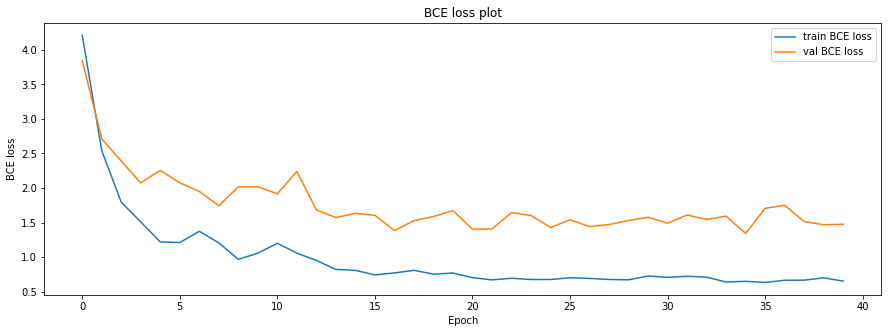

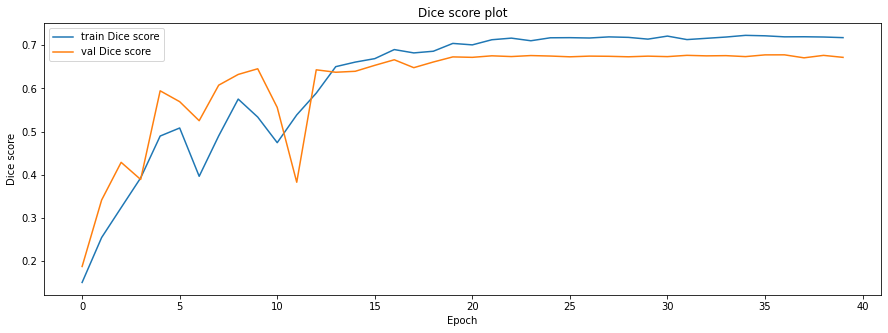

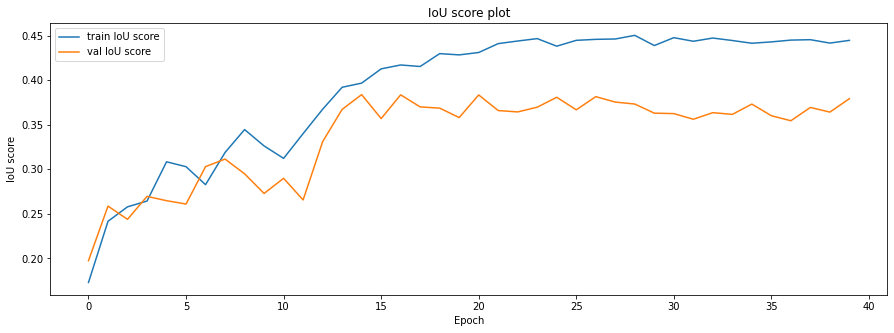

In [57]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

### Output

In [58]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensorV2(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [59]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 16
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
model = model_trainer.net # get the model from model_trainer object
model.eval()
state = torch.load('./model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)

NameError: name 'sample_submission_path' is not defined

In [ ]:
df.head()